Close to "Spatial_Join" notebook, but using PostGIS database instead of simple (geo)pandas.

Start Docker with:

docker run --name some-postgis -e POSTGRES_PASSWORD=mysecretpassword -p 5432:5432 -d postgis/postgis

docker logs -f some-postgis

Wait until "LOG:  database system is ready to accept connections" (might take several minutes)

Requires : geoalchemy2
Doesn't work for geopandas 0.8, only for 0.9

In [1]:
import pandas.io.sql as psql
import pandas as pd
import psycopg2 as pg
from sqlalchemy import create_engine

import geopandas as gpd
import requests

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [13]:
pg_host="localhost"
pg_port="5432"
pg_dbname="postgres"
pg_user="postgres"
pg_password="example"

pg_schema = "gistest"
connection_string =f"host='{pg_host}' port={pg_port} dbname={pg_dbname} user={pg_user}  password={pg_password}"
engine_url=f"postgresql+psycopg2://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_dbname}"

In [14]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [15]:
def get_request(query, params=None):
#     with pg.connect(database='postgres', user='postgres', host='localhost', password='example') as connection:
    with pg.connect(connection_string) as connection:    
        connection.set_session(readonly=True)
        return psql.read_sql(query, connection, params=params)


In [16]:
def get_geo_request(query, params=None):
#     with pg.connect(database='postgres', user='postgres', host='localhost', password='example') as connection:
    with pg.connect(connection_string) as connection:    
        connection.set_session(readonly=True)
        return gpd.read_postgis(query, connection, params=params, geom_col="geometry")



In [17]:
def run_request(query, params=None):
    with pg.connect(connection_string) as connection:    
        psql.execute(query, connection, params=params)


In [18]:
def add_basemap(ax):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Load data

In [21]:
run_request(f"CREATE SCHEMA IF NOT EXISTS {pg_schema};")

OperationalError: could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?


In [474]:
run_request(f"DROP TABLE IF EXISTS {pg_schema}.nis_boundaries")
run_request(f"DROP TABLE IF EXISTS {pg_schema}.zip_commune_boundaries")
run_request(f"DROP TABLE IF EXISTS {pg_schema}.zip_commune_boundaries_filled")

In [25]:
get_request(f"""SELECT * 
FROM pg_catalog.pg_tables
WHERE schemaname = '{pg_schema}';""")

OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


## Zipcode list

In [58]:
zipcodes = pd.read_excel("data/zipcodes_alpha_fr_new.xls")
zipcodes = zipcodes.rename({"Code postal":"zipcode", 
                            "Commune principale": "main_commune", 
                            "Localité":"locality",
                            "Province": "province",
                            "Sous-commune": "is_sub_commune"}, axis=1)
zipcodes["zipcode"] = zipcodes["zipcode"].astype(str)
zipcodes["is_special"] = zipcodes["is_sub_commune"].isnull()
zipcodes = zipcodes.sort_values("zipcode")
zipcodes["province"] = zipcodes.province.fillna(method="ffill")
print(zipcodes.zipcode.nunique(), "unique zipcodes")
zipcodes

1190 unique zipcodes


,zipcode,locality,is_sub_commune,main_commune,province,is_special
384,1000,Bruxelles,Non,BRUXELLES,BRUXELLES,False
92,1005,Assemblée Réunie de la Commission Communautaire,NaN,Assemblée Réunie de la Commission Communautaire,BRUXELLES,True
1964,1006,Raad van de Vlaamse Gemeenschapscommissie,NaN,Raad van de Vlaamse Gemeenschapscommissie,BRUXELLES,True
91,1007,Assemblée de la Commission Communautaire Franç...,NaN,Assemblée de la Commission Communautaire Franç...,BRUXELLES,True
424,1008,Chambre des Représentants,NaN,Chambre des Représentants,BRUXELLES,True
...,...,...,...,...,...,...
2608,9988,Waterland-Oudeman,Oui,SINT-LAUREINS,FLANDRE-ORIENTALE,False
2611,9988,Watervliet,Oui,SINT-LAUREINS,FLANDRE-ORIENTALE,False
1450,9990,Maldegem,Non,MALDEGEM,FLANDRE-ORIENTALE,False
20,9991,Adegem,Oui,MALDEGEM,FLANDRE-ORIENTALE,False


In [59]:
engine = create_engine(engine_url)
zipcodes.to_sql(name="zipcodes", con=engine, if_exists="replace", schema=pg_schema, index=False)

In [60]:
get_request(f"""SELECT *
FROM {pg_schema}.zipcodes;""")

,zipcode,locality,is_sub_commune,main_commune,province,is_special
0,1000,Bruxelles,Non,BRUXELLES,BRUXELLES,False
1,1005,Assemblée Réunie de la Commission Communautaire,None,Assemblée Réunie de la Commission Communautaire,BRUXELLES,True
2,1006,Raad van de Vlaamse Gemeenschapscommissie,None,Raad van de Vlaamse Gemeenschapscommissie,BRUXELLES,True
3,1007,Assemblée de la Commission Communautaire Franç...,None,Assemblée de la Commission Communautaire Franç...,BRUXELLES,True
4,1008,Chambre des Représentants,None,Chambre des Représentants,BRUXELLES,True
...,...,...,...,...,...,...
2760,9988,Waterland-Oudeman,Oui,SINT-LAUREINS,FLANDRE-ORIENTALE,False
2761,9988,Watervliet,Oui,SINT-LAUREINS,FLANDRE-ORIENTALE,False
2762,9990,Maldegem,Non,MALDEGEM,FLANDRE-ORIENTALE,False
2763,9991,Adegem,Oui,MALDEGEM,FLANDRE-ORIENTALE,False


## Zipcode boundaries

In [61]:
zipcode_boundaries_filename = "data/zipcode_boundaries_shapefile_3812.zip"

zipcodes_boundaries = gpd.read_file(f"zip://{zipcode_boundaries_filename}/3812")
zipcodes_boundaries["is_special"] = zipcodes_boundaries.CP_speciau ==1
zipcodes_boundaries = zipcodes_boundaries.rename({"nouveau_PO":"zipcode"}, axis=1)[["zipcode", "is_special", "geometry"]]

zipcodes_boundaries = zipcodes_boundaries.dissolve(["zipcode", "is_special"]).reset_index()

zipcodes_boundaries = zipcodes_boundaries.to_crs(osm_crs)
zipcodes_boundaries

,zipcode,is_special,geometry
0,1000,False,"MULTIPOLYGON Z (((4.38334 50.87982 0.00000, 4...."
1,1005,True,"POLYGON Z ((4.35137 50.84458 0.00000, 4.35158 ..."
2,1006,True,"POLYGON Z ((4.35156 50.84513 0.00000, 4.35099 ..."
3,1007,True,"POLYGON Z ((4.36790 50.84690 0.00000, 4.36802 ..."
4,1008,True,"POLYGON Z ((4.36582 50.84691 0.00000, 4.36469 ..."
...,...,...,...
1182,9982,False,"POLYGON Z ((3.57643 51.27498 0.00000, 3.57666 ..."
1183,9988,False,"POLYGON Z ((3.61271 51.29793 0.00000, 3.61273 ..."
1184,9990,False,"POLYGON Z ((3.44165 51.24318 0.00000, 3.44176 ..."
1185,9991,False,"POLYGON Z ((3.49864 51.22072 0.00000, 3.49942 ..."


In [62]:
engine = create_engine(engine_url)
zipcodes_boundaries.to_postgis(name="zipcodes_boundaries", con=engine, if_exists="replace", schema=pg_schema)

In [1]:
get_geo_request(f"""SELECT *
FROM {pg_schema}.zipcodes_boundaries;""")

NameError: name 'get_geo_request' is not defined

## Zipcode centers

In [66]:
zipcodes_centers = gpd.read_file("data/zipcode_centers.geojson")
zipcodes_centers = zipcodes_centers.rename({"column_1": "zipcode", "column_2": "locality"}, axis=1)[["locality","zipcode", "geometry"]]

zipcodes_centers = zipcodes_centers.to_crs(osm_crs)
print(zipcodes_centers.zipcode.nunique(), "unique zipcode")
zipcodes_centers

1145 unique zipcode


,locality,zipcode,geometry
0,Saint-Gilles,1060,POINT (4.34567 50.82674)
1,Molenbeek-Saint-Jean,1080,POINT (4.32278 50.85436)
2,Ganshoren,1083,POINT (4.31751 50.87124)
3,Neder-Over-Heembeek,1120,POINT (4.39049 50.89780)
4,Wavre,1300,POINT (4.60774 50.71642)
...,...,...,...
2752,Dikkelvenne,9890,POINT (3.68945 50.91767)
2753,Lovendegem,9920,POINT (3.60761 51.09568)
2754,Zomergem,9930,POINT (3.56424 51.11958)
2755,Waarschoot,9950,POINT (3.60617 51.15153)


In [67]:
# zipcodes_centers.plot()

In [68]:
engine = create_engine(engine_url)  
zipcodes_centers.to_postgis(name="zipcodes_centers", con=engine, if_exists="replace", schema=pg_schema)

In [69]:
get_geo_request(f"""SELECT *
FROM {pg_schema}.zipcodes_centers;""")

,locality,zipcode,geometry
0,Saint-Gilles,1060,POINT (4.34567 50.82674)
1,Molenbeek-Saint-Jean,1080,POINT (4.32278 50.85436)
2,Ganshoren,1083,POINT (4.31751 50.87124)
3,Neder-Over-Heembeek,1120,POINT (4.39049 50.89780)
4,Wavre,1300,POINT (4.60774 50.71642)
...,...,...,...
2752,Dikkelvenne,9890,POINT (3.68945 50.91767)
2753,Lovendegem,9920,POINT (3.60761 51.09568)
2754,Zomergem,9930,POINT (3.56424 51.11958)
2755,Waarschoot,9950,POINT (3.60617 51.15153)


## Statistical sectors

In [238]:
statistical_sectors = gpd.read_file("zip://data/stat_sectors_2020.zip/sh_statbel_statistical_sectors_20200101.shp")
statistical_sectors["CNIS5_2020"] = statistical_sectors["CNIS5_2020"].astype(str)
statistical_sectors = statistical_sectors.to_crs(osm_crs)
statistical_sectors.columns= statistical_sectors.columns.str.lower()


In [241]:
engine = create_engine(engine_url)  
statistical_sectors.to_postgis(name="statistical_sectors", con=engine, if_exists="replace", schema=pg_schema)

In [12]:
sectors = get_request(f"""SELECT *
FROM {pg_schema}.statistical_sectors;""")
sectors

,cs01012020,t_sec_nl,t_sec_fr,t_sec_de,c_nis6,t_nis6_nl,t_nis6_fr,cnis5_2020,t_mun_nl,t_mun_fr,...,t_regio_nl,t_regio_fr,t_regio_de,c_country,nuts1,nuts2,nuts3,m_area_ha,m_peri_m,geometry
0,11001A00-,AARTSELAAR-CENTRUM,AARTSELAAR-CENTRUM,AARTSELAAR-CENTRUM,11001A,AARTSELAAR,AARTSELAAR,11001,Aartselaar,Aartselaar,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,53.158103,5248.0,01030000A0E6100000010000009300000027AE79B5E491...
1,11001A01-,DE LEEUWERIK,DE LEEUWERIK,DE LEEUWERIK,11001A,AARTSELAAR,AARTSELAAR,11001,Aartselaar,Aartselaar,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,67.114679,3935.0,01030000A0E6100000010000006C000000BF3A94433093...
2,11001A020,BUERSTEDE,BUERSTEDE,BUERSTEDE,11001A,AARTSELAAR,AARTSELAAR,11001,Aartselaar,Aartselaar,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,28.084365,2202.0,01030000A0E61000000100000034000000D4F1B29DEA82...
3,11001A030,YSSELAAR,YSSELAAR,YSSELAAR,11001A,AARTSELAAR,AARTSELAAR,11001,Aartselaar,Aartselaar,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,42.811849,3403.0,01030000A0E61000000100000031010000A292C6F2CA90...
4,11001A042,KLEINE GRIPPE,KLEINE GRIPPE,KLEINE GRIPPE,11001A,AARTSELAAR,AARTSELAAR,11001,Aartselaar,Aartselaar,...,Vlaams Gewest,Région flamande,Flämische Region,BE,BE2,BE21,BE211,25.561955,2166.0,01030000A0E6100000010000003A000000BF3A94433093...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19789,93090G191,BOIS DE NISMES,BOIS DE NISMES,BOIS DE NISMES,93090G,NISMES,NISMES,93090,Viroinval,Viroinval,...,Waals Gewest,Région wallonne,Wallonische Region,BE,BE3,BE35,BE353,1507.153385,24359.0,01030000A0E610000002000000D702000085D1D1CCC163...
19790,93090H000,DOURBES-CENTRE,DOURBES-CENTRE,DOURBES-CENTRE,93090H,DOURBES*,DOURBES*,93090,Viroinval,Viroinval,...,Waals Gewest,Région wallonne,Wallonische Region,BE,BE3,BE35,BE353,19.381890,2569.0,01030000A0E610000001000000470000007C617990215B...
19791,93090H012,DOURBES ROUTE DE MARIEMBOURG,DOURBES ROUTE DE MARIEMBOURG,DOURBES ROUTE DE MARIEMBOURG,93090H,DOURBES*,DOURBES*,93090,Viroinval,Viroinval,...,Waals Gewest,Région wallonne,Wallonische Region,BE,BE3,BE35,BE353,19.369718,2411.0,01030000A0E610000001000000410000007C617990215B...
19792,93090H063,LORET,LORET,LORET,93090H,DOURBES*,DOURBES*,93090,Viroinval,Viroinval,...,Waals Gewest,Région wallonne,Wallonische Region,BE,BE3,BE35,BE353,24.865501,2559.0,01030000A0E61000000100000032000000538EA3F3385D...


In [11]:
# Niss boundaries 

nis_boundaries= get_geo_request(f"""
SELECT cnis5_2020, t_mun_nl, t_mun_fr, ST_Union(geometry) as geometry
FROM {pg_schema}.statistical_sectors
GROUP BY cnis5_2020, t_mun_nl, t_mun_fr;""")
nis_boundaries

,cnis5_2020,t_mun_nl,t_mun_fr,geometry
0,11001,Aartselaar,Aartselaar,"POLYGON Z ((4.37085 51.11013 0.00000, 4.36937 ..."
1,11002,Antwerpen,Anvers,"POLYGON Z ((4.35607 51.20341 0.00000, 4.35595 ..."
2,11004,Boechout,Boechout,"POLYGON Z ((4.52182 51.14748 0.00000, 4.52177 ..."
3,11005,Boom,Boom,"POLYGON Z ((4.38839 51.08384 0.00000, 4.38832 ..."
4,11007,Borsbeek,Borsbeek,"POLYGON Z ((4.50235 51.19112 0.00000, 4.50213 ..."
...,...,...,...,...
576,93018,Doische,Doische,"POLYGON Z ((4.62817 50.09562 0.00000, 4.62770 ..."
577,93022,Florennes,Florennes,"POLYGON Z ((4.76349 50.21722 0.00000, 4.76339 ..."
578,93056,Philippeville,Philippeville,"POLYGON Z ((4.58440 50.10740 0.00000, 4.58441 ..."
579,93088,Walcourt,Walcourt,"POLYGON Z ((4.52308 50.27092 0.00000, 4.52305 ..."


In [17]:
# Province boundaries 
nis_provinces= get_geo_request(f"""
SELECT c_provi, t_provi_fr, t_provi_nl, t_regio_nl, t_regio_fr,  ST_Union(geometry) as geometry
FROM {pg_schema}.statistical_sectors
GROUP BY c_provi, t_provi_fr, t_provi_nl, t_regio_nl, t_regio_fr""")
nis_provinces

,c_provi,t_provi_fr,t_provi_nl,t_regio_nl,t_regio_fr,geometry
0,-,None,None,Brussels Hoofdstedelijk Gewest,Région de Bruxelles-Capitale,"POLYGON Z ((4.29740 50.81001 0.00000, 4.29735 ..."
1,10000,Province d’Anvers,Provincie Antwerpen,Vlaams Gewest,Région flamande,"MULTIPOLYGON Z (((4.93579 51.40930 0.00000, 4...."
2,20001,Province du Brabant flamand,Provincie Vlaams-Brabant,Vlaams Gewest,Région flamande,"POLYGON Z ((5.10784 50.72285 0.00000, 5.10736 ..."
3,20002,Province du Brabant wallon,Provincie Waals-Brabant,Waals Gewest,Région wallonne,"POLYGON Z ((4.14575 50.63660 0.00000, 4.14578 ..."
4,30000,Province de Flandre occidentale,Provincie West-Vlaanderen,Vlaams Gewest,Région flamande,"POLYGON Z ((2.84230 50.73559 0.00000, 2.84250 ..."
5,40000,Province de Flandre orientale,Provincie Oost-Vlaanderen,Vlaams Gewest,Région flamande,"POLYGON Z ((3.49165 50.75792 0.00000, 3.49161 ..."
6,50000,Province du Hainaut,Provincie Henegouwen,Waals Gewest,Région wallonne,"MULTIPOLYGON Z (((2.91167 50.70400 0.00000, 2...."
7,60000,Province de Liège,Provincie Luik,Waals Gewest,Région wallonne,"POLYGON Z ((5.35148 50.38838 0.00000, 5.35144 ..."
8,70000,Province du Limbourg,Provincie Limburg,Vlaams Gewest,Région flamande,"MULTIPOLYGON Z (((5.89564 50.74545 0.00000, 5...."
9,80000,Province du Luxembourg,Provincie Luxemburg,Waals Gewest,Région wallonne,"POLYGON Z ((5.01249 49.99737 0.00000, 5.01249 ..."


<AxesSubplot:>

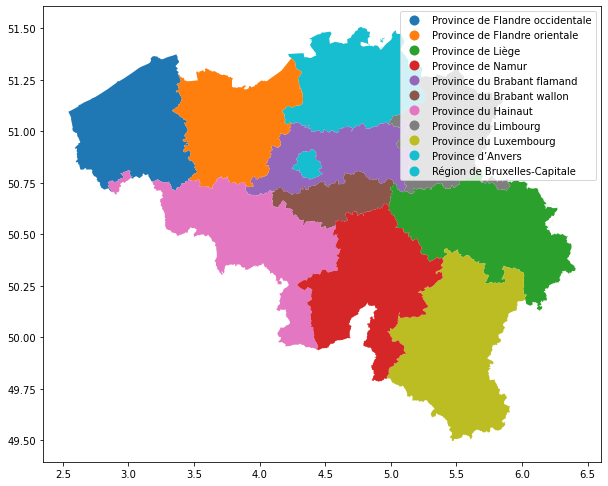

In [26]:
nis_provinces.assign(label=nis_provinces.t_provi_fr.fillna(nis_provinces.t_regio_fr)).plot("label", legend=True, figsize=(10,10))

## Views

In [475]:
run_request(f"""
CREATE TABLE {pg_schema}.nis_boundaries AS
    SELECT cnis5_2020, t_mun_nl, t_mun_fr, ST_Union(geometry) as geometry
    FROM {pg_schema}.statistical_sectors
    GROUP BY cnis5_2020, t_mun_nl, t_mun_fr
    """)


In [476]:
run_request(f"""
CREATE TABLE {pg_schema}.zip_commune_boundaries AS
    SELECT main_commune, ST_Union(geometry) as geometry
    FROM {pg_schema}.zipcodes zp 
      JOIN {pg_schema}.zipcodes_boundaries zp_bnd 
      ON zp.zipcode = zp_bnd.zipcode
    where NOT zp.is_special
    GROUP BY main_commune
    """)

In [478]:
get_request(f"SELECT * FROM {pg_schema}.zipcodes_boundaries ")

,zipcode,is_special,geometry
0,1000,False,01060000A0E6100000050000000103000080070000009E...
1,1005,True,01030000A0E610000001000000090000003D373065CC67...
2,1006,True,01030000A0E610000001000000080000008B1D8563FE67...
3,1007,True,01030000A0E6100000010000000600000006897794BA78...
4,1008,True,01030000A0E610000001000000060000008CA2FF469876...
...,...,...,...
1182,9982,False,01030000A0E610000001000000470100001278574E869C...
1183,9988,False,01030000A0E6100000010000000C0200005B5F448AD4E6...
1184,9990,False,01030000A0E610000001000000EC020000FF9BE0508288...
1185,9991,False,01030000A0E610000001000000B0020000007CE0DE34FD...


In [481]:
# Fill holes left by special codes. Only for zone fully included in a "normal" zone
run_request(f"""
CREATE TABLE {pg_schema}.zip_commune_boundaries_filled AS
    SELECT main_commune, ST_Collect(ST_MakePolygon(geometry)) As geometry
    FROM (
        SELECT main_commune, ST_ExteriorRing((ST_Dump(geometry)).geom) As geometry
        FROM  {pg_schema}.zip_commune_boundaries 
    ) s
    GROUP BY main_commune
    """)


# Queries

## Join zip centers-boundaries

In [482]:
sjoin_zip_center = get_request(f"""
SELECT bnd.zipcode as bnd_zipcode, ctr.zipcode as ctr_zipcode, locality
FROM {pg_schema}.zipcodes_boundaries bnd, {pg_schema}.zipcodes_centers ctr
WHERE ST_Contains(bnd.geometry, ctr.geometry)
""")
sjoin_zip_center

,bnd_zipcode,ctr_zipcode,locality
0,1060,1060,Saint-Gilles
1,1080,1080,Molenbeek-Saint-Jean
2,1083,1083,Ganshoren
3,1120,1120,Neder-Over-Heembeek
4,1300,1300,Wavre
...,...,...,...
2752,9890,9890,Dikkelvenne
2753,9920,9920,Lovendegem
2754,9930,9930,Zomergem
2755,9950,9950,Waarschoot


In [483]:
sjoin_mismatches = get_request(f"""
SELECT bnd.zipcode as bnd_zipcode, ctr.zipcode as ctr_zipcode, locality
FROM {pg_schema}.zipcodes_boundaries bnd, {pg_schema}.zipcodes_centers ctr
WHERE ST_Contains(bnd.geometry, ctr.geometry)
AND   bnd.zipcode != ctr.zipcode
ORDER BY bnd.zipcode
""")
sjoin_mismatches

,bnd_zipcode,ctr_zipcode,locality
0,1130,3700,Haren
1,1541,8600,Driekapellen
2,2000,2030,Antwerpen
3,2000,2060,Antwerpen
4,2000,2018,Antwerpen
5,2000,2050,Antwerpen
6,2000,2020,Antwerpen
7,2000,2040,Antwerpen
8,2180,2223,Schriek
9,2180,3400,Laar


In [485]:
get_request(f"""
SELECT zipcode, ST_Area(geometry), ST_Length(ST_Boundary(geometry))
FROM {pg_schema}.zipcodes_boundaries bnd

""")

,zipcode,st_area,st_length
0,1000,1.467467e-03,0.674274
1,1005,2.059788e-07,0.001768
2,1006,1.366610e-07,0.001785
3,1007,1.863360e-07,0.002019
4,1008,5.448798e-07,0.003302
...,...,...,...
1182,9982,1.714060e-03,0.216499
1183,9988,3.844306e-03,0.378281
1184,9990,8.137429e-03,0.566609
1185,9991,3.352091e-03,0.338254


In [28]:
zipcodes_boundaries.area

<ipython-input-28-99aaeb574896>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zipcodes_boundaries.area


0       1.467467e-03
1       2.059788e-07
2       1.366610e-07
3       1.863360e-07
4       5.448798e-07
            ...     
1182    1.714060e-03
1183    3.844306e-03
1184    8.137429e-03
1185    3.352091e-03
1186    8.082315e-04
Length: 1187, dtype: float64

## Province boundaries

In [189]:
crs

'epsg:3857'

In [486]:
prov = get_geo_request(f"""
SELECT zipcode, ST_Transform(geometry, 31370) as geometry
FROM {pg_schema}.zipcodes_boundaries
""")
prov

,zipcode,geometry
0,1000,MULTIPOLYGON Z (((151026.522 174383.511 -42.83...
1,1005,"POLYGON Z ((148775.482 170463.452 -42.857, 148..."
2,1006,"POLYGON Z ((148788.927 170524.548 -42.857, 148..."
3,1007,"POLYGON Z ((149939.927 170721.301 -42.865, 149..."
4,1008,"POLYGON Z ((149793.162 170723.079 -42.864, 149..."
...,...,...
1182,9982,"POLYGON Z ((94708.930 218639.620 -41.791, 9472..."
1183,9988,"POLYGON Z ((97266.682 221166.886 -41.785, 9726..."
1184,9990,"POLYGON Z ((85260.390 215211.179 -41.745, 8526..."
1185,9991,"POLYGON Z ((89209.935 212664.039 -41.811, 8926..."


In [198]:
prov = get_geo_request(f"""
SELECT zp.province, ST_Union(geometry) as geom, 
    ST_Area(ST_Transform(ST_Union(geometry), 31370))/1000^2 as prov_area
    
FROM {pg_schema}.zipcodes_boundaries bnd
    JOIN {pg_schema}.zipcodes zp 
    ON bnd.zipcode = zp.zipcode
GROUP BY zp.province
""")
prov

,province,geom,prov_area
0,ANVERS,"MULTIPOLYGON Z (((4.94163 51.45557 0.00000, 4....",2876.169790
1,BRABANT FLAMAND,"POLYGON Z ((4.03636 50.69643 0.00000, 4.03315 ...",2118.372560
2,BRABANT WALLON,"POLYGON Z ((4.17736 50.66342 0.00000, 4.17700 ...",1097.193392
3,BRUXELLES,"POLYGON Z ((4.47027 50.78976 0.00000, 4.46491 ...",162.422254
4,FLANDRE-OCCIDENTALE,"POLYGON Z ((3.40308 50.74162 0.00000, 3.40303 ...",3182.506707
5,FLANDRE-ORIENTALE,"POLYGON Z ((3.67751 50.77070 0.00000, 3.67760 ...",3007.122573
6,HAINAUT,"MULTIPOLYGON Z (((4.35320 50.85014 0.00000, 4....",3813.106963
7,LIEGE,"POLYGON Z ((5.42193 50.43061 0.00000, 5.42058 ...",3857.181214
8,LIMBOURG,"MULTIPOLYGON Z (((5.89564 50.74545 0.00000, 5....",2427.453160
9,LUXEMBOURG,"POLYGON Z ((5.84859 49.59720 0.00000, 5.84877 ...",4459.322510


In [172]:
statistical_sectors = gpd.read_file("zip://data/stat_sectors_2020.zip/sh_statbel_statistical_sectors_20200101.shp")
statistical_sectors["CNIS5_2020"] = statistical_sectors["CNIS5_2020"].astype(str)

In [179]:
prov_nis = statistical_sectors[["T_PROVI_FR", "geometry"]].dissolve("T_PROVI_FR")

In [181]:
prov_nis.assign(ar=prov_nis.area/(1000**2))

,geometry,ar
T_PROVI_FR,,
Province de Flandre occidentale,"POLYGON Z ((83489.530 159995.491 0.000, 83488....",3196.622714
Province de Flandre orientale,"POLYGON Z ((98736.032 158867.058 0.000, 98719....",3007.110723
Province de Liège,"POLYGON Z ((276506.515 96694.991 0.000, 276514...",3857.173434
Province de Namur,"POLYGON Z ((193240.987 54915.334 0.000, 193226...",3674.826625
Province du Brabant flamand,"POLYGON Z ((126516.330 154035.693 0.000, 12651...",2118.387343
Province du Brabant wallon,"POLYGON Z ((150959.609 139257.480 0.000, 15088...",1097.197952
Province du Hainaut,"MULTIPOLYGON Z (((154103.564 70323.214 0.000, ...",3812.900166
Province du Limbourg,"MULTIPOLYGON Z (((205615.858 154477.589 0.000,...",2427.449046
Province du Luxembourg,"POLYGON Z ((234354.943 23041.209 0.000, 234310...",4459.336047


## Commune boundaries

In [451]:
commune_boundaries = get_geo_request(f"""
SELECT * from {pg_schema}.zip_commune_boundaries_filled
""")
commune_boundaries

,main_commune,geom
0,AALST,"MULTIPOLYGON Z (((3.99584 50.93822 0.00000, 3...."
1,AALTER,"MULTIPOLYGON Z (((3.50421 51.07037 0.00000, 3...."
2,AARSCHOT,"MULTIPOLYGON Z (((4.90238 50.99611 0.00000, 4...."
3,AARTSELAAR,"MULTIPOLYGON Z (((4.40142 51.14983 0.00000, 4...."
4,AFFLIGEM,"MULTIPOLYGON Z (((4.13900 50.91693 0.00000, 4...."
...,...,...
576,ZULTE,"MULTIPOLYGON Z (((3.52661 50.94769 0.00000, 3...."
577,ZUTENDAAL,"MULTIPOLYGON Z (((5.59532 50.97730 0.00000, 5...."
578,ZWALM,"MULTIPOLYGON Z (((3.72545 50.91205 0.00000, 3...."
579,ZWEVEGEM,"MULTIPOLYGON Z (((3.39176 50.75286 0.00000, 3...."


In [452]:
overlaps = get_geo_request(f"""
SELECT cnis5_2020, t_mun_fr, main_commune, 
    nis_bnd.geom as nis_geom,
    zip_bnd.geom as zip_geom,
    ST_Intersection(nis_bnd.geom, zip_bnd.geom) as geom,
    ST_Area(ST_Intersection(nis_bnd.geom, zip_bnd.geom)) / ST_Area(nis_bnd.geom) as overlap_ratio
    
FROM {pg_schema}.nis_boundaries nis_bnd
JOIN {pg_schema}.zip_commune_boundaries_filled zip_bnd
ON ST_Intersects(nis_bnd.geom, zip_bnd.geom)

""")
overlaps

,cnis5_2020,t_mun_fr,main_commune,nis_geom,zip_geom,geom,overlap_ratio
0,23002,Asse,AALST,01030000A0E610000001000000D41000000B68248EE2F5...,01060000A0E61000000100000001030000800100000070...,"MULTIPOLYGON Z (((4.13900 50.91693 0.00000, 4....",2.082180e-06
1,23060,Opwijk,AALST,01030000A0E6100000010000002C0C00006EBC1BD2C0B1...,01060000A0E61000000100000001030000800100000070...,"MULTIPOLYGON Z (((4.16236 50.93238 0.00000, 4....",5.367030e-06
2,23105,Affligem,AALST,01030000A0E6100000010000005A0600009D748D540775...,01060000A0E61000000100000001030000800100000070...,"MULTIPOLYGON Z (((4.07424 50.89940 0.00000, 4....",2.153376e-05
3,41002,Alost,AALST,01030000A0E610000001000000981200008C8EF1323792...,01060000A0E61000000100000001030000800100000070...,"POLYGON Z ((4.14279 50.92387 0.00000, 4.14275 ...",9.939421e-01
4,41011,Denderleeuw,AALST,01030000A0E610000001000000480800003D74A8D45A36...,01060000A0E61000000100000001030000800100000070...,"MULTIPOLYGON Z (((4.04152 50.90451 0.00000, 4....",8.348838e-05
...,...,...,...,...,...,...,...
3797,34043,Espierres-Helchin,ZWEVEGEM,01030000A0E6100000010000007A050000A109BF1663DF...,01060000A0E61000000100000001030000800100000006...,"MULTIPOLYGON Z (((3.35986 50.73748 0.00000, 3....",9.206079e-06
3798,11002,Anvers,ZWIJNDRECHT,01030000A0E610000001000000D8160000C572B9609E6C...,01060000A0E610000001000000010300008001000000EB...,"MULTIPOLYGON Z (((4.35607 51.20341 0.00000, 4....",1.526778e-06
3799,11056,Zwijndrecht,ZWIJNDRECHT,01030000A0E61000000100000084020000BAE752DADE4C...,01060000A0E610000001000000010300008001000000EB...,"POLYGON Z ((4.32507 51.18663 0.00000, 4.32501 ...",9.999781e-01
3800,46003,Beveren,ZWIJNDRECHT,01030000A0E610000001000000530800003FF65CDB94D8...,01060000A0E610000001000000010300008001000000EB...,"MULTIPOLYGON Z (((4.29132 51.25214 0.00000, 4....",5.230534e-07


<AxesSubplot:>

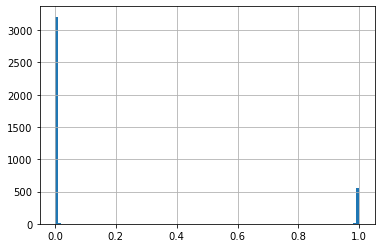

In [261]:
overlaps.overlap_ratio.hist(bins=100)

In [453]:
overlaps2 = get_geo_request(f"""
SELECT cnis5_2020, t_mun_fr, main_commune, 
    nis_bnd.geom as nis_geom,
    zip_bnd.geom as zip_geom,
    ST_Difference(nis_bnd.geom, zip_bnd.geom) as only_nis_geom,
    ST_Difference(zip_bnd.geom, nis_bnd.geom) as only_zip_geom,
    ST_Intersection(nis_bnd.geom, zip_bnd.geom) as geom,
    ST_Area(ST_Intersection(nis_bnd.geom, zip_bnd.geom)) / ST_Area(nis_bnd.geom) as overlap_ratio
    
FROM {pg_schema}.nis_boundaries nis_bnd
JOIN {pg_schema}.zip_commune_boundaries_filled zip_bnd
ON ST_Intersects(nis_bnd.geom, zip_bnd.geom) AND 
   ST_Area(ST_Intersection(nis_bnd.geom, zip_bnd.geom)) / ST_Area(nis_bnd.geom) > 0.5 

""")

# Convert geometry columns
overlaps2.nis_geom =      overlaps2.nis_geom.apply(     shapely.wkb.loads, hex=True)
overlaps2.zip_geom =      overlaps2.zip_geom.apply(     shapely.wkb.loads, hex=True)
overlaps2.only_nis_geom = overlaps2.only_nis_geom.apply(shapely.wkb.loads, hex=True)
overlaps2.only_zip_geom = overlaps2.only_zip_geom.apply(shapely.wkb.loads, hex=True)

overlaps2

<AxesSubplot:>

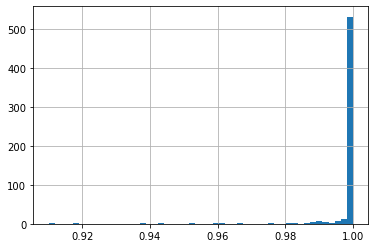

In [454]:
overlaps2.overlap_ratio.hist(bins=50)

In [457]:
overlaps2.sort_values("overlap_ratio").iloc[0:20]

,cnis5_2020,t_mun_fr,main_commune,nis_geom,zip_geom,only_nis_geom,only_zip_geom,geom,overlap_ratio
119,35029,De Haan,DE HAAN,01030000A0E61000000100000002060000DB122286B17C...,01060000A0E61000000100000001030000800100000045...,01060000A0E61000007D00000001030000800100000004...,01060000A0E61000007D00000001030000800100000076...,"POLYGON Z ((3.06089 51.23242 0.00000, 3.06079 ...",0.910084
280,31043,Knokke-Heist,KNOKKE-HEIST,01030000A0E610000001000000E70200001D7A82782242...,01060000A0E6100000010000000103000080010000007B...,01060000A0E61000001E00000001030000800100000019...,01060000A0E61000001E00000001030000800100000007...,"POLYGON Z ((3.27612 51.30119 0.00000, 3.27534 ...",0.917736
89,21004,Bruxelles,BRUXELLES,01030000A0E610000001000000B20C00006AC51F94E885...,01060000A0E61000000600000001030000800100000015...,01060000A0E6100000D8000000010300008001000000F9...,01060000A0E6100000DC00000001030000800100000037...,"MULTIPOLYGON Z (((4.38068 50.83864 0.00000, 4....",0.937348
34,13002,Baerle-Duc,BAARLE-HERTOG,01060000A0E61000001A00000001030000800100000020...,01060000A0E61000001700000001030000800100000053...,01060000A0E6100000DB00000001030000800100000020...,01060000A0E6100000E000000001030000800100000010...,"MULTIPOLYGON Z (((4.93579 51.40930 0.00000, 4....",0.942526
524,23088,Vilvorde,VILVOORDE,01030000A0E610000001000000C1090000C994A61B9BB7...,01060000A0E610000001000000010300008001000000C2...,01060000A0E61000008800000001030000800100000007...,01060000A0E61000008800000001030000800100000013...,"POLYGON Z ((4.42930 50.92045 0.00000, 4.42702 ...",0.952227
368,35011,Middelkerke,MIDDELKERKE,01030000A0E6100000010000008909000058DC49A5A21D...,01060000A0E610000001000000010300008001000000AF...,01060000A0E6100000B50000000103000080010000000E...,01060000A0E6100000B500000001030000800100000005...,"POLYGON Z ((2.76342 51.13898 0.00000, 2.76296 ...",0.959975
138,23098,Drogenbos,DROGENBOS,01030000A0E61000000100000039040000554BAE8DC546...,01060000A0E610000001000000010300008001000000B3...,01060000A0E61000005D00000001030000800100000008...,01060000A0E61000005D0000000103000080010000005D...,"POLYGON Z ((4.31911 50.77989 0.00000, 4.31371 ...",0.961104
345,23047,Machelen,MACHELEN,01030000A0E61000000100000052020000AA8B37B78AD3...,01060000A0E610000001000000010300008001000000A3...,01060000A0E61000003400000001030000800100000007...,01060000A0E61000003400000001030000800100000005...,"POLYGON Z ((4.45658 50.88892 0.00000, 4.45632 ...",0.967020
377,25068,Mont-Saint-Guibert,MONT-SAINT-GUIBERT,01030000A0E61000000100000065050000B272269D2388...,01060000A0E61000000200000001030000800100000062...,01060000A0E61000007500000001030000800100000015...,01060000A0E61000007600000001030000800100000004...,"MULTIPOLYGON Z (((4.63315 50.63093 0.00000, 4....",0.976050
214,56086,Ham-sur-Heure-Nalinnes,HAM-SUR-HEURE,01030000A0E610000001000000C2080000433EBD436E90...,01060000A0E610000001000000010300008001000000C2...,01060000A0E6100000A200000001030000800100000008...,01060000A0E6100000A200000001030000800100000048...,"POLYGON Z ((4.39092 50.29246 0.00000, 4.39090 ...",0.981030


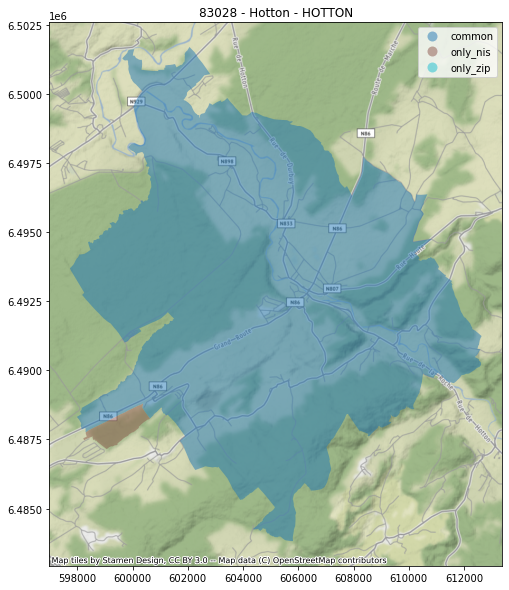

In [460]:
i=248
rec = overlaps2.loc[i]
gdf = gpd.GeoDataFrame([["only_nis", rec.only_nis_geom],
                        ["only_zip", rec.only_zip_geom],
                        ["common",   rec.geom]], columns=["name", "geometry"])
gdf = gdf.set_crs(osm_crs).to_crs(crs)

ax = gdf.plot("name", legend=True, figsize=(10,10), alpha=0.5)
ax.set_title(f"{rec.cnis5_2020} - {rec.t_mun_fr} - {rec.main_commune}")
add_basemap(ax)

,cnis5_2020,t_mun_fr,main_commune,zipcode,overlap_ratio,geom
0,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
1,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
2,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
3,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
4,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
5,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
6,83028,Hotton,MARCHE-EN-FAMENNE,6900,0.012117,"POLYGON Z ((5.37387 50.27889 0.00000, 5.37398 ..."
7,83028,Hotton,HOTTON,6990,0.987869,"POLYGON Z ((5.41258 50.31572 0.00000, 5.41385 ..."
8,83028,Hotton,HOTTON,6990,0.987869,"POLYGON Z ((5.41258 50.31572 0.00000, 5.41385 ..."
9,83028,Hotton,HOTTON,6990,0.987869,"POLYGON Z ((5.41258 50.31572 0.00000, 5.41385 ..."


<AxesSubplot:>

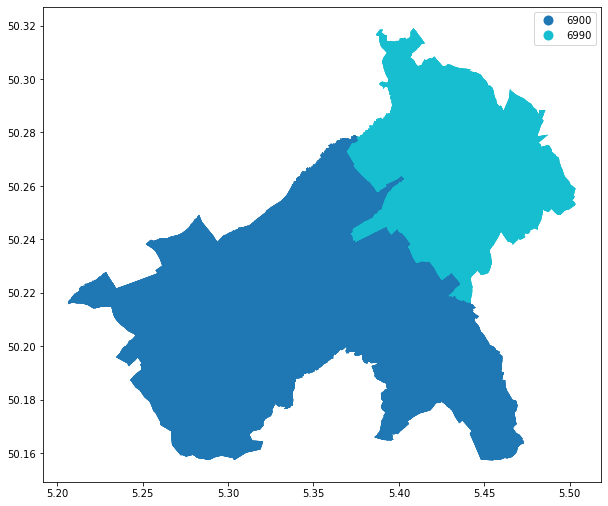

In [462]:
nis = 83028
zip_overlaps= get_geo_request(f"""
SELECT cnis5_2020, t_mun_fr, main_commune, zip_bnd.zipcode,

ST_Area(ST_Intersection(nis_bnd.geom, zip_bnd.geometry)) / ST_Area(nis_bnd.geom) as overlap_ratio,
zip_bnd.geometry as geom

FROM {pg_schema}.nis_boundaries nis_bnd
JOIN {pg_schema}.zipcodes_boundaries zip_bnd
    ON ST_Intersects(nis_bnd.geom, zip_bnd.geometry)
JOIN {pg_schema}.zipcodes zip 
    ON zip.zipcode=zip_bnd.zipcode 
   
WHERE cnis5_2020 = '{nis}'
    AND ST_Area(ST_Intersection(nis_bnd.geom, zip_bnd.geometry)) / ST_Area(nis_bnd.geom)  > 0.001
ORDER BY overlap_ratio
""")
display(zip_overlaps)
zip_overlaps.plot("zipcode", legend=True, figsize=(10,10))

# Tests

In [55]:
get_request(f"""

SELECT a.locality, b.locality, ST_AsText(a.geometry),
    ST_Distance(a.geometry, b.geometry), 
    a.geometry <-> b.geometry as dist, 
    ST_Distance(ST_Transform(a.geometry, 3857), ST_Transform(b.geometry, 3857)),
    (ST_Transform(a.geometry, 3857) <-> ST_Transform(b.geometry, 3857))*cosd(ST_Y(a.geometry)) as dist_corrected,
    ST_DistanceSphere(a.geometry, b.geometry)
FROM {pg_schema}.zipcodes_centers a, {pg_schema}.zipcodes_centers b
WHERE a.zipcode='1160' and b.zipcode='5190'
""")

,locality,locality,st_astext,st_distance,dist,st_distance,dist_corrected,st_distancesphere
0,Auderghem,Balâtre,POINT(4.4331389 50.8156571),0.377856,0.377856,60220.074695,38048.097741,38134.345601
1,Auderghem,Moustier-Sur-Sambre,POINT(4.4331389 50.8156571),0.437830,0.437830,68020.978469,42976.845352,43089.000477
2,Auderghem,Saint-Martin,POINT(4.4331389 50.8156571),0.380737,0.380737,60201.952678,38036.647933,38121.847291
3,Auderghem,Ham-Sur-Sambre,POINT(4.4331389 50.8156571),0.442193,0.442193,70418.685388,44491.758571,44618.069937
4,Auderghem,Mornimont,POINT(4.4331389 50.8156571),0.450833,0.450833,70049.784058,44258.680251,44379.139044
5,Auderghem,Spy,POINT(4.4331389 50.8156571),0.429590,0.429590,65946.306841,41666.031486,41768.067932
6,Auderghem,Jemeppe-Sur-Sambre,POINT(4.4331389 50.8156571),0.416430,0.416430,66630.555134,42098.351540,42209.589491
7,Auderghem,Onoz,POINT(4.4331389 50.8156571),0.400612,0.400612,62579.259317,39538.671898,39630.807359
